## **Introduction to the Project**

##### *The course-end project analyzes sentiments expressed in over 34,000 reviews for Amazon brand products within the e-commerce domain. The dataset contains attributes such as brand, categories, review titles, review text, and sentiment levels categorized into "Positive," "Negative," and "Neutral." The project aims to predict sentiment or satisfaction levels based on various features and review text.*


#### **Import of Libraries**

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')


In [73]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
test_data_hidden = pd.read_csv('test_data_hidden.csv')

#### **Exploration of Data Analysis**

In [74]:
train_data.info()
test_data.info()
test_data_hidden.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  4000 non-null   object
 1   Product Brand        4000 non-null   object
 2   categories           4000 non-null   object
 3   primaryCategories    4000 non-null   object
 4   reviews.date         4000 non-null   object
 5   reviews.text         4000 non-null   object
 6   reviews.title        3990 non-null   object
 7   sentiment            4000 non-null   object
dtypes: object(8)
memory usage: 250.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name of the product  1000 non-null   object
 1   Product Brand        1000 non-null   object
 2   categories           1000 non-null   object
 3   primary

#### **Finding Missing Values**

In [75]:
train_data.isnull().sum()


Name of the product     0
Product Brand           0
categories              0
primaryCategories       0
reviews.date            0
reviews.text            0
reviews.title          10
sentiment               0
dtype: int64

In [76]:
test_data.isnull().sum()


Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          3
dtype: int64

In [77]:
test_data_hidden.isnull().sum()

Name of the product    0
Product Brand          0
categories             0
primaryCategories      0
reviews.date           0
reviews.text           0
reviews.title          3
sentiment              0
dtype: int64

#### **Filling Null Values**

In [78]:
train_data['reviews.title'].fillna('', inplace=True)
test_data['reviews.title'].fillna('', inplace=True)
test_data_hidden['reviews.title'].fillna('', inplace=True)


#### **Distribution of Sentiment Analysis**

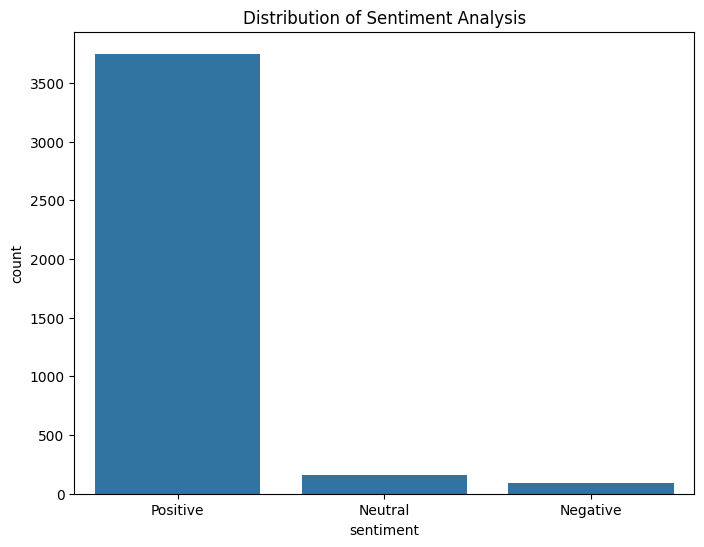

In [79]:
plt.figure(figsize=(8, 6))
sns.countplot(data=train_data, x='sentiment')
plt.title('Distribution of Sentiment Analysis')
plt.show()

#### **Mergering Train and Test Dataset**

In [80]:
all_data = pd.concat([train_data, test_data])


In [81]:
most_frequent_sentiment = all_data['sentiment'].mode()[0]
all_data['sentiment'].fillna(most_frequent_sentiment, inplace=True)


#### **Spliting the Dataset into Train and Test data** 

Since the test dataset does not include a Sentiment column, we first merged it with the training dataset and then split them again.

In [82]:
train_data, test_data1 = train_test_split(all_data, test_size=0.2, stratify=all_data['sentiment'], random_state=42)

print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data1.shape}')

Training data shape: (4000, 8)
Test data shape: (1000, 8)


#### **Mergering the Title and Text column**

In [83]:
train_data['combined_text'] = train_data['reviews.title'] + ' ' + train_data['reviews.text']
test_data1['combined_text'] = test_data1['reviews.title'] + ' ' + test_data1['reviews.text']
test_data_hidden['combined_text'] = test_data_hidden['reviews.title'] + ' ' + test_data_hidden['reviews.text']

# Separate texts for training, testing, and hidden test sets
X_train_texts = train_data['combined_text']
X_test_texts = test_data1['combined_text']
X_hidden_texts = test_data_hidden['combined_text']

#### **Remove the Stop Words**

In [84]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)


In [85]:
X_train_texts = X_train_texts.apply(preprocess_text)
X_test_texts = X_test_texts.apply(preprocess_text)
X_hidden_texts = X_hidden_texts.apply(preprocess_text)


#### **Sentiment Word Cloud**

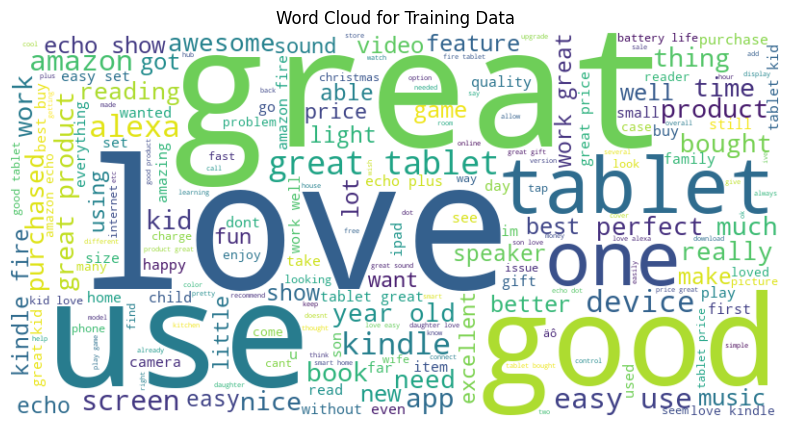

In [86]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(X_train_texts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Training Data')
plt.show()

In [87]:
train_data1=train_data.copy()

#### **Positive, Negative and Neutral Words Cloud**

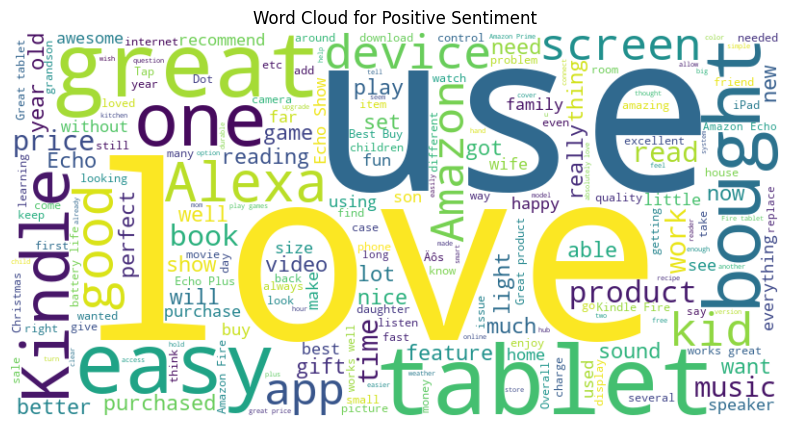

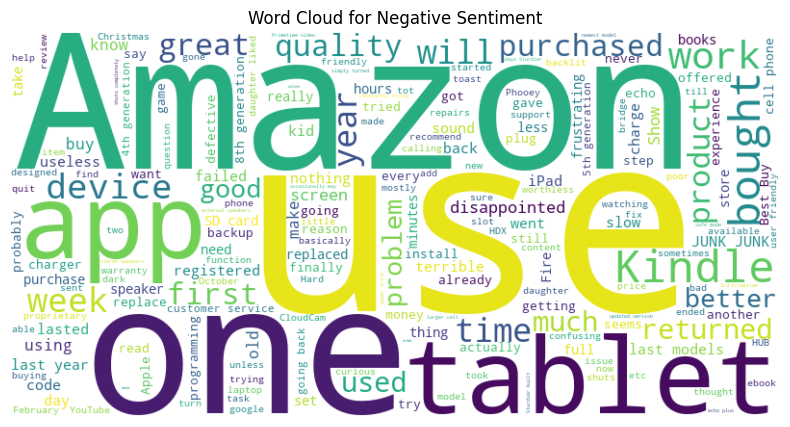

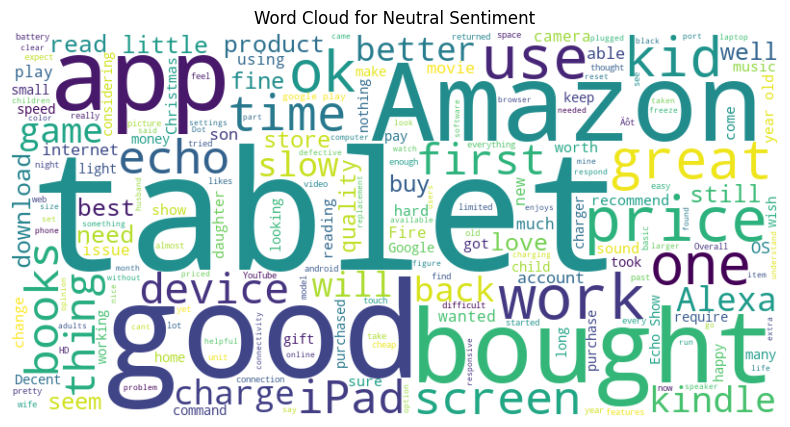

In [88]:
sentiments = ['Positive', 'Negative', 'Neutral']

# Convert sentiment column to lowercase
train_data1['sentiment'] = train_data1['sentiment'].str.lower()

# Iterate over lowercase sentiment categories and generate word clouds
for sentiment in sentiments:
    # Filter data for the current sentiment
    sentiment_data = train_data1[train_data1['sentiment'] == sentiment.lower()]
    
    if not sentiment_data.empty:
        # Join all texts corresponding to the current sentiment category
        text = ' '.join(sentiment_data['reviews.text'])
        
        # Generate word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment')
        plt.show()
    else:
        print(f"No data available for {sentiment} sentiment.")

#### **Feature Engineering - Term Frequency-Inverse Document Frequency**

In [89]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train_texts)
X_test_tfidf = tfidf.transform(X_test_texts)
X_hidden_tfidf = tfidf.transform(X_hidden_texts)

print(X_train_tfidf.shape, X_test_tfidf.shape, X_hidden_tfidf.shape)

(4000, 4996) (1000, 4996) (1000, 4996)


#### **Class Imbalance**

In [90]:
# Apply SMOTE to handle class imbalance in training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tfidf, train_data['sentiment'])

# Check the new class distribution
print(pd.Series(y_train_res).value_counts())


sentiment
Positive    3799
Negative    3799
Neutral     3799
Name: count, dtype: int64


#### **Sentiment Distribution after Class Balance**

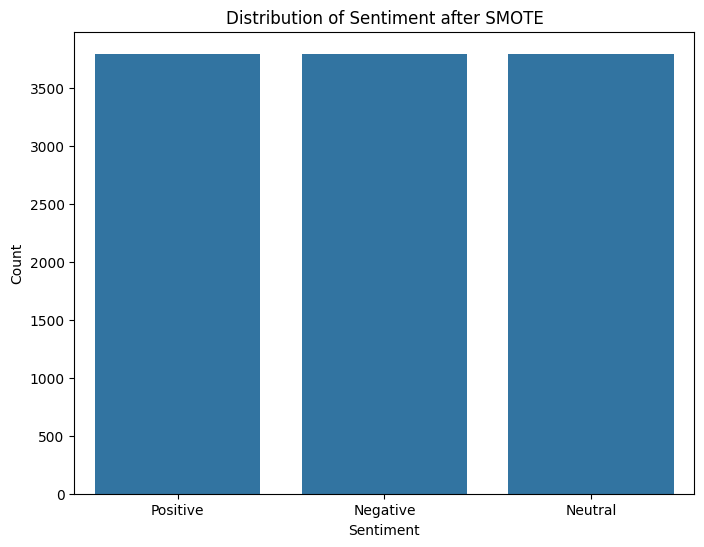

In [91]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_res)
plt.title('Distribution of Sentiment after SMOTE')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

#### **Multinomial Naive Bayes Classifier**

In [92]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the model
y_pred_nb = nb_classifier.predict(X_test_tfidf)

print(classification_report(test_data1['sentiment'], y_pred_nb))
print('Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_nb))


              precision    recall  f1-score   support

    Negative       0.27      0.37      0.31        19
     Neutral       0.15      0.48      0.22        31
    Positive       0.97      0.89      0.93       950

    accuracy                           0.87      1000
   macro avg       0.46      0.58      0.49      1000
weighted avg       0.93      0.87      0.90      1000

Accuracy: 0.87


#### **Confusion Matrix**

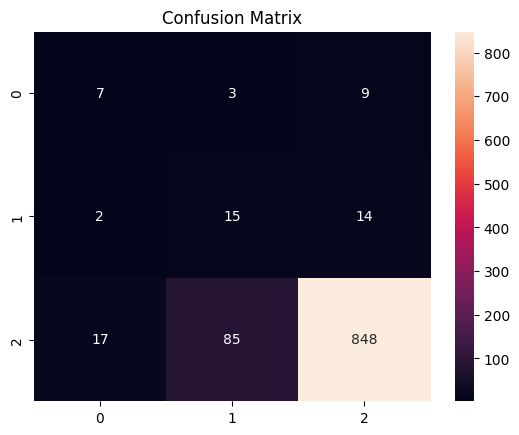

In [93]:
conf_matrix = confusion_matrix(test_data1['sentiment'], y_pred_nb)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.show()

#### **Area Under the Receiver Operating Characteristic (ROC) curve**

In [94]:
y_pred_prob_nb = nb_classifier.predict_proba(X_test_tfidf)
y_test_bin = pd.get_dummies(test_data1['sentiment'])
print("ROC AUC Score: ", roc_auc_score(y_test_bin, y_pred_prob_nb, multi_class='ovr'))

ROC AUC Score:  0.8671724014099373


#### **Multi-class Support Vector Machines**

In [95]:
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the SVM model
y_pred_svm = svm_classifier.predict(X_test_tfidf)

print('SVM Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_svm))
print('SVM Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_svm))

SVM Accuracy: 0.94
SVM Classification Report:
               precision    recall  f1-score   support

    Negative       0.45      0.26      0.33        19
     Neutral       0.30      0.29      0.30        31
    Positive       0.97      0.97      0.97       950

    accuracy                           0.94      1000
   macro avg       0.57      0.51      0.53      1000
weighted avg       0.94      0.94      0.94      1000



#### **Multi-layer perceptron (MLP) neural network**

In [96]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='adam', random_state=42)
mlp_classifier.fit(X_train_res, y_train_res)

# Make predictions and evaluate the MLP model
y_pred_mlp = mlp_classifier.predict(X_test_tfidf)

print('MLP Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_mlp))
print('MLP Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_mlp))

MLP Accuracy: 0.942
MLP Classification Report:
               precision    recall  f1-score   support

    Negative       0.46      0.32      0.38        19
     Neutral       0.35      0.29      0.32        31
    Positive       0.96      0.98      0.97       950

    accuracy                           0.94      1000
   macro avg       0.59      0.53      0.55      1000
weighted avg       0.94      0.94      0.94      1000



#### **Ensemble Techniques**

In [97]:
ensemble = VotingClassifier(estimators=[
    ('nb', nb_classifier),
    ('svm', svm_classifier),
    ('mlp', mlp_classifier)
], voting='soft')

ensemble.fit(X_train_res, y_train_res)

# Make predictions using the ensemble
y_pred_ensemble = ensemble.predict(X_test_tfidf)

print('Ensemble Accuracy:', accuracy_score(test_data1['sentiment'], y_pred_ensemble))
print('Ensemble Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_ensemble))

Ensemble Accuracy: 0.95
Ensemble Classification Report:
               precision    recall  f1-score   support

    Negative       0.71      0.26      0.38        19
     Neutral       0.39      0.23      0.29        31
    Positive       0.96      0.99      0.97       950

    accuracy                           0.95      1000
   macro avg       0.69      0.49      0.55      1000
weighted avg       0.94      0.95      0.94      1000



#### **Label Encoding**

In [98]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode target variable in training set
y_train_encoded = label_encoder.fit_transform(y_train_res)


#### **XGBoost**

In [99]:
from xgboost import XGBClassifier

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the classifier on the resampled training data
xgb_classifier.fit(X_train_res, y_train_encoded)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [100]:
# Make predictions on the test set
y_pred_xgb = xgb_classifier.predict(X_test_tfidf)

# Convert numeric predictions back to string labels using LabelEncoder
y_pred_xgb_labels = label_encoder.inverse_transform(y_pred_xgb)

# Calculate accuracy using accuracy_score
accuracy_xgb = accuracy_score(test_data1['sentiment'], y_pred_xgb_labels)

# Print accuracy and classification report
print('XGBoost Accuracy:', accuracy_xgb)
print('XGBoost Classification Report:\n', classification_report(test_data1['sentiment'], y_pred_xgb_labels))

XGBoost Accuracy: 0.95
XGBoost Classification Report:
               precision    recall  f1-score   support

    Negative       0.43      0.16      0.23        19
     Neutral       0.41      0.29      0.34        31
    Positive       0.97      0.99      0.98       950

    accuracy                           0.95      1000
   macro avg       0.60      0.48      0.52      1000
weighted avg       0.94      0.95      0.94      1000



#### **Tokenizer**

In [101]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_data['combined_text'])

X_train_seq = tokenizer.texts_to_sequences(train_data['combined_text'])
X_test_seq = tokenizer.texts_to_sequences(test_data1['combined_text'])

X_train_pad = pad_sequences(X_train_seq, maxlen=500)
X_test_pad = pad_sequences(X_test_seq, maxlen=500)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(test_data1['sentiment'])

y_train_cat = to_categorical(y_train_encoded, num_classes=3)
y_test_cat = to_categorical(y_test_encoded, num_classes=3)


#### **Long Short-Term Memory (LSTM) networks**

In [102]:
# LSTM model architecture
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=500))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.2)

# Evaluate LSTM model
y_pred_lstm = model.predict(X_test_pad)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
print(classification_report(y_test_encoded, y_pred_lstm_classes))  # Use encoded test labels for classification report


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 440ms/step - accuracy: 0.9055 - loss: 0.5473 - val_accuracy: 0.9475 - val_loss: 0.2412
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 423ms/step - accuracy: 0.9509 - loss: 0.2279 - val_accuracy: 0.9475 - val_loss: 0.2340
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.9512 - loss: 0.2163 - val_accuracy: 0.9475 - val_loss: 0.2316
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 428ms/step - accuracy: 0.9537 - loss: 0.1655 - val_accuracy: 0.9475 - val_loss: 0.2221
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 420ms/step - accuracy: 0.9616 - loss: 0.1157 - val_accuracy: 0.9525 - val_loss: 0.2290
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 453ms/step - accuracy: 0.9711 - loss: 0.0851 - val_accuracy: 0.9488 - val_loss: 0.2739
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.9824 - loss: 0.0630 - val_accuracy: 0.9400 - val_loss: 0.2877
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 458ms/step - accuracy: 0.9916 - loss: 0.0397 - val_accu

#### **Accuracy and Loss from LSTM Training**

Epoch 1/10


50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step - accuracy: 0.9948 - loss: 0.0163 - val_accuracy: 0.9350 - val_loss: 0.4198
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 441ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9350 - val_loss: 0.4537
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 432ms/step - accuracy: 0.9924 - loss: 0.0191 - val_accuracy: 0.9300 - val_loss: 0.4521
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 427ms/step - accuracy: 0.9957 - loss: 0.0148 - val_accuracy: 0.9300 - val_loss: 0.4572
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 430ms/step - accuracy: 0.9963 - loss: 0.0125 - val_accuracy: 0.9287 - val_loss: 0.4738
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - accuracy: 0.9967 - loss: 0.0117 - val_accuracy: 0.9300 - val_loss: 0.4645
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 439ms/step - accuracy: 0.9960 - loss: 0.0103 - val_accuracy: 0.9200 - val_loss: 0.4866
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 429ms/step - accuracy: 0.9942 - loss: 0.0132 - val_accuracy: 0.911

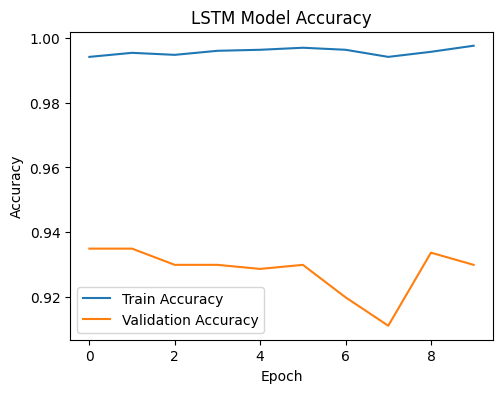

In [103]:
# Visualize accuracy and loss for LSTM training
history = model.fit(X_train_pad, y_train_cat, epochs=10, batch_size=64, validation_split=0.2)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#### **LSTM Model Loss**

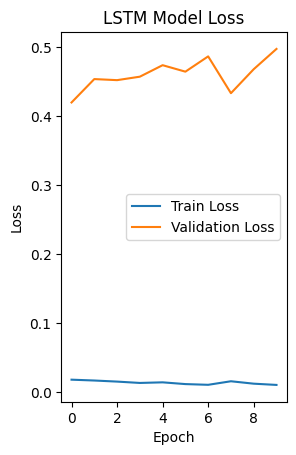

In [104]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#### **Export the prediction to CSV**

In [105]:
X_hidden_seq = tokenizer.texts_to_sequences(test_data_hidden['combined_text'])
X_hidden_pad = pad_sequences(X_hidden_seq, maxlen=500)

# Make predictions using the LSTM model on hidden test data
y_pred_hidden_lstm_prob = model.predict(X_hidden_pad)
y_pred_hidden_lstm = np.argmax(y_pred_hidden_lstm_prob, axis=1)

# Decode the predicted sentiments
y_pred_hidden_lstm_decoded = label_encoder.inverse_transform(y_pred_hidden_lstm)

# Add predictions to the hidden test data
test_data_hidden['predicted_sentiment'] = y_pred_hidden_lstm_decoded

# Save the predictions
test_data_hidden.to_csv('hidden_test_data_with_predictions.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step


#### **Cross Validation**

In [106]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cross_val_score_manual(model_fn, X, y, params, cv=3):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = model_fn(**params)
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)
        
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_classes = np.argmax(y_val, axis=1)
        
        scores.append(accuracy_score(y_val_classes, y_pred_classes))
    
    return np.mean(scores)

#### **Grid Search and Cross Validation function for LSTM Model**

In [107]:
import numpy as np
import itertools
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Dummy data for example purposes (replace with your actual data)
# X should be your padded sequences, and y should be your labels
# Replace these lines with your actual data loading/preprocessing
X = np.random.randint(1, 5000, size=(11397, 500))  # Example padded sequences
y = np.random.randint(0, 3, size=(11397,))        # Example labels (3 classes)

# Function to create the LSTM model
def create_lstm_model(optimizer='adam', input_dim=5000, output_dim=128, input_length=500, dropout=0.2, recurrent_dropout=0.2):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(LSTM(128, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Custom cross-validation function with early stopping
def cross_val_score_manual(model_fn, X, y, params, cv=3):
    kfold = KFold(n_splits=cv, shuffle=True, random_state=42)
    scores = []
    early_stopping = EarlyStopping(monitor='val_loss', patience=2)  # Define early_stopping here

    for train_idx, val_idx in kfold.split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = model_fn(optimizer=params['optimizer'])
        model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, 
                  validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_val_classes = np.argmax(y_val, axis=1)
        
        scores.append(accuracy_score(y_val_classes, y_pred_classes))
    
    return np.mean(scores)

# Custom grid search function
def grid_search_manual(model_fn, param_grid, X, y, cv=3):
    keys, values = zip(*param_grid.items())
    best_score = 0
    best_params = None

    for params in itertools.product(*values):
        param_dict = dict(zip(keys, params))
        score = cross_val_score_manual(model_fn, X, y, param_dict, cv=cv)
        if score > best_score:
            best_score = score
            best_params = param_dict

    return best_params, best_score

# Assuming you have the following preprocessed data
# X, y should be your features and labels

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define parameter grid with reduced values for initial tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],  # Reduced batch size
    'epochs': [5, 10]  # Reduced epochs
}



#### **Best Parameters and Best Score**

In [108]:
# Conduct grid search
best_params, best_score = grid_search_manual(create_lstm_model, param_grid, X_train, y_train_cat, cv=3)
print("Best Grid Search Parameters: ", best_params)
print("Best Grid Search Score: ", best_score)

# Evaluate the best model on the test set
best_model = create_lstm_model(optimizer=best_params['optimizer'])
best_model.fit(X_train, y_train_cat, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, 
               validation_data=(X_test, y_test_cat), callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

y_pred_lstm = best_model.predict(X_test)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
print(classification_report(y_test, y_pred_lstm_classes))  # Use test labels for classification report

84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 95ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step
Best Grid Search Parameters:  {'opti

#### **Non-Negative Matrix Factorization**

In [109]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Assuming X_train_texts contains preprocessed text data

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_train_texts)

# NMF Model
num_topics = 5  # Adjust as needed
nmf_model = NMF(n_components=num_topics, random_state=42)
nmf_model.fit(X_tfidf)

# Print the topics
feature_names = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))
    print()

Topic 0:
tablet great price good amazon little nice work need child

Topic 1:
echo alexa show amazon music love device sound plus home

Topic 2:
love kid gift bought old year great christmas son grandson

Topic 3:
easy use product great set work good recommend price item

Topic 4:
kindle fire book read love reading one new much best



#### **Latent Dirichlet Allocation (LDA)**

In [110]:

# Example preprocessing steps
stop_words = set(stopwords.words('english'))

# Remove punctuation and lowercase
X_train_texts = [text.translate(str.maketrans('', '', string.punctuation)).lower() for text in X_train_texts]

# Tokenize and remove stopwords
X_train_texts = [" ".join([word for word in word_tokenize(text) if word not in stop_words]) for text in X_train_texts]

# Initialize Tf-Idf Vectorizer
tfidf = TfidfVectorizer(max_features=10000)  # Adjust max_features as needed
X_train_tfidf = tfidf.fit_transform(X_train_texts)

# LDA
lda = LatentDirichletAllocation(n_components=7, random_state=42)
X_lda = lda.fit_transform(X_train_tfidf)

# Display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Get feature names from tfidf vectorizer
feature_names = tfidf.get_feature_names_out()

# Use display_topics function
display_topics(lda, feature_names, 10)  # Adjust number of top words as needed

Topic 0:
tablet great love kid price easy gift use bought good
Topic 1:
tablet great love kindle good work product kid use easy
Topic 2:
basic intercom childrens box operation alexas function combo ad tabletreader
Topic 3:
exactly ebook need hand tablet screen android expect good controlling
Topic 4:
love one echo thing like great much use hue kindle
Topic 5:
love great alexa äôs it family echo bought äôt gift
Topic 6:
echo alexa great love product show sound device home music
